In [2]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import pandas as pd
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

# # Import MINST data #we are not working with this particular data set in this notebook. Data set used is imported later.
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

C:\Anaconda2\envs\cnn2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Utils 

In [12]:
# create a object for getting the Batch.
class Batch(object):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
        self.size = x.shape[0]
    def getBatch(self):
        indices = np.random.randint(low=0,high=self.size, size=self.batch_size) #includes low and excludes high
        return self.x[indices, :]

# Read Data 

In [4]:
# pandas to masage the data.
df = pd.read_csv('fashion-mnist_train.csv', skiprows=[0], header=None)
df = df.drop(df.columns[0], axis=1)
x_train = np.float32(df.values)/255.0

df_2 = pd.read_csv('fashion-mnist_test.csv', skiprows=[0], header=None)
df_2 = df_2.drop(df_2.columns[0], axis=1)
x_test = np.float32(df_2.values)/255.0

#l = pd.read_csv('../input/fashion-mnist_train.csv', skiprows = [0], usecols = [0], header=None)
#x_label = np.float32(l.values)

num_samples = x_train.shape[0]
num_cols = x_train.shape[1]

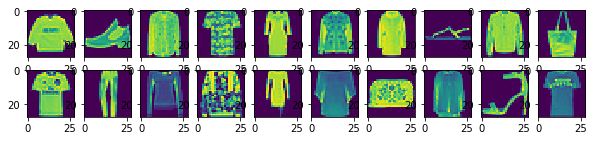

In [5]:
# quick check about what we've already imported here.
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    a[0][i].imshow(np.reshape(x_train[i], (28, 28)))
    a[1][i].imshow(np.reshape(x_test[i], (28, 28)))

Any action in tensorflow (tf) needs the creation of an independent session.

**Note:** It is recommended to not run two tf sessions together on the same gpu as many times it will lead either one or both sessions crashing.

In [11]:
# quick check about what we exactly convert to. ==> This is an irrelevent cell. 
x_train_tf = tf.convert_to_tensor(x_train, np.float32)
sess = tf.InteractiveSession()  
print(x_train_tf.eval())
sess.close()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Model 

Now, let's give the parameters that are going to be used by our NN.

In [6]:
learning_rate = 0.01
training_epochs = 20
batch_size = 256 #power of 2 because that augments GPU performance (something to do with virtual to physical processor mapping)
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 512#256 # 1st layer num features
n_hidden_2 = 256#128 # 2nd layer num features
n_hidden_3 = 128
n_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
#     'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
#     'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
#     'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
#     'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),   
#     'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
#     'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
#     'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
#     'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
#     'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
#     'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

In [7]:
# Building the encoder
def encoder(x):
    # Encoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),biases['encoder_b1']))
    # Encoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),biases['encoder_b2']))
    return layer_2

In [8]:
# Building the decoder
def decoder(x):
    # Decoder first layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),biases['decoder_b1']))
    # Decoder second layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),biases['decoder_b2']))
    return layer_2

Let's construct our model.
In the variable `cost` we have the loss function and in the `optimizer` variable we have our gradient used for backpropagation.

In [9]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the mean squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

#### - We will use sess.run defined as follows: (https://www.tensorflow.org/api_docs/python/tf/Session)

    run(
    fetches,
    feed_dict=None,
    options=None,
    run_metadata=None
)

Runs operations and evaluates tensors in fetches.

__Args:__

    fetches: A single graph element, a list of graph elements, or a dictionary whose values are graph elements or lists of graph elements (described above).
    feed_dict: A dictionary that maps graph elements to values (described above).
    options: A [RunOptions] protocol buffer
    run_metadata: A [RunMetadata] protocol buffer

__Returns:___

Either a single value if fetches is a single graph element, or a list of values if fetches is a list, or a dictionary with the same keys as fetches if that is a dictionary (described above). Order in which fetches operations are evaluated inside the call is undefined.

__Notes:__
This method runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values.

The fetches argument may be a single graph element, or an arbitrarily nested list, tuple, namedtuple, dict, or OrderedDict containing graph elements at its leaves. A graph element can be one of the following types:

    - A tf.Operation. The corresponding fetched value will be None.
    - A tf.Tensor. The corresponding fetched value will be a numpy ndarray containing the value of that tensor.
    - A tf.SparseTensor. The corresponding fetched value will be a tf.SparseTensorValue containing the value of that sparse tensor.
    - A get_tensor_handle op. The corresponding fetched value will be a numpy ndarray containing the handle of that tensor.
    - A string which is the name of a tensor or operation in the graph.

The value returned by run() has the same shape as the fetches argument, where the leaves are replaced by the corresponding values returned by TensorFlow.


#### - The training will run for 20 epochs

In [14]:
%%time
# Launch the graph
# Using InteractiveSession (more convenient while using Notebooks)
sess = tf.InteractiveSession()
sess.run(init)

num_batches = int(num_samples/batch_size)
batch = Batch(x_train, batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(num_batches):
        try:
            batch_xs = batch.getBatch() #we only need to create batched of feature set and not labels
        except:
            pdb.set_trace()
        # Run optimization Op (backprop) on cost Op to to get loss value. 
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs}) #Returns None, value of the cost function
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(c))
print("Optimization Finished!")

Epoch: 0001 cost= 0.195325777
Epoch: 0002 cost= 0.161497712
Epoch: 0003 cost= 0.157385483
Epoch: 0004 cost= 0.146449745
Epoch: 0005 cost= 0.141619459
Epoch: 0006 cost= 0.135694504
Epoch: 0007 cost= 0.131644771
Epoch: 0008 cost= 0.130343035
Epoch: 0009 cost= 0.130280346
Epoch: 0010 cost= 0.125770658
Epoch: 0011 cost= 0.142064273
Epoch: 0012 cost= 0.140042543
Epoch: 0013 cost= 0.124609619
Epoch: 0014 cost= 0.118121222
Epoch: 0015 cost= 0.123149261
Epoch: 0016 cost= 0.125100255
Epoch: 0017 cost= 0.126953721
Epoch: 0018 cost= 0.122345045
Epoch: 0019 cost= 0.117381349
Epoch: 0020 cost= 0.118495055
Optimization Finished!
Wall time: 6min 39s


Now, let's apply encode and decode for our tests.

In [17]:
%%time
# Applying encode and decode over test set
encode_decode = sess.run(y_pred, feed_dict={X: x_test[:examples_to_show]}) #returns ypred val for each input val in feed_dict
encode_decode_trn = sess.run(y_pred, feed_dict={X: x_train[:examples_to_show]})

Wall time: 15.6 ms


Let's simply visualize our train, test and reconstructed data!

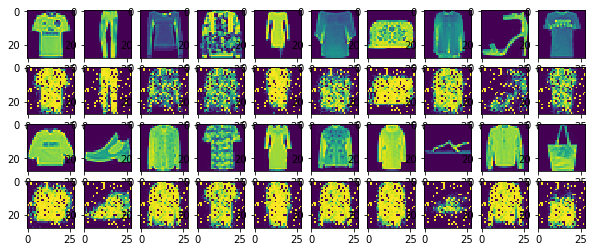

In [18]:
# Compare original images with their reconstructions
f, a = plt.subplots(4, 10, figsize=(10, 4))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_test[i], (28, 28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    a[2][i].imshow(np.reshape(x_train[i], (28, 28)))
    a[3][i].imshow(np.reshape(encode_decode_trn[i], (28, 28)))